In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lavanyakohli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
#load the data
df = pd.read_csv("twitter_training.csv", names=col_names)
df

,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [3]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Entity     74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
# Check Data Dimensions
df.shape

(74682, 4)

In [5]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      686
dtype: int64

In [6]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [7]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 2340


In [8]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [9]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

### Exploratory Data Analysis

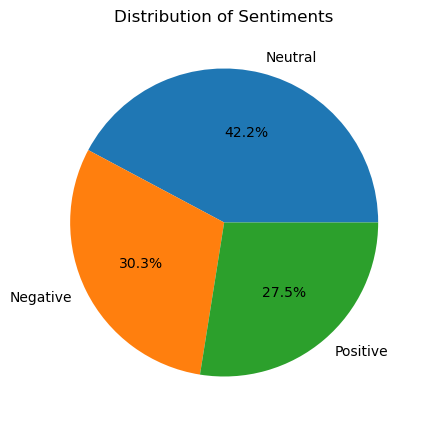

In [10]:
#calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%')
plt.title('Distribution of Sentiments')
plt.show()

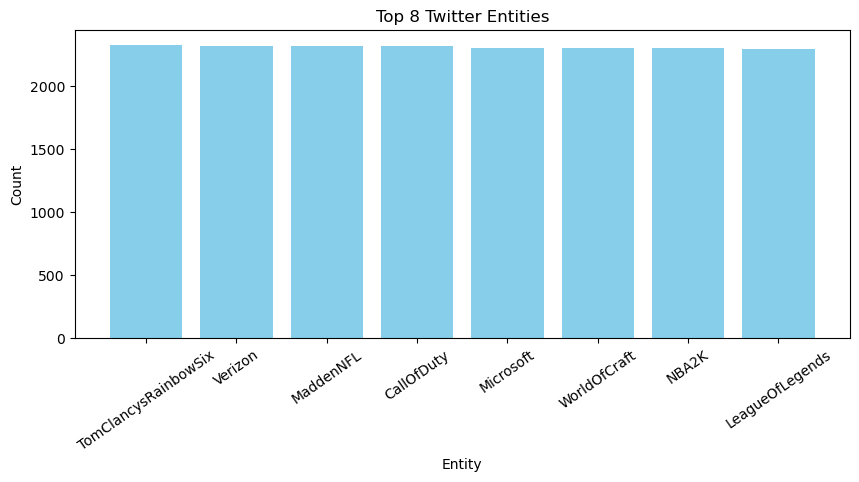

In [11]:
#calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

#select the top 8 entities
top_8_entities = entity_distribution.head(8)

#create a bar chart for the top 10 entities
plt.figure(figsize=(10, 4))
plt.bar(top_8_entities.index, top_8_entities.values, color='skyblue')
plt.title('Top 8 Twitter Entities')
plt.xlabel('Entity')
plt.ylabel('Count')

#rotate the x-axis labels for better readability
plt.xticks(rotation=35)
plt.show()

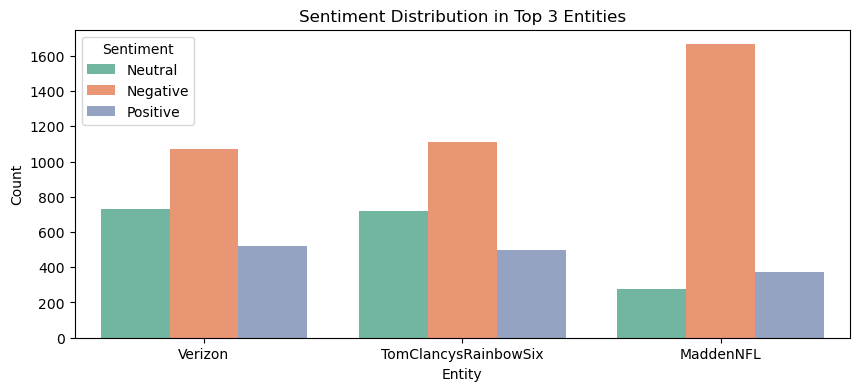

In [12]:
#calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()

#select the top 3 entities
top_3_entities = entity_distribution.head(3).index

#filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]

#create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 4))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.show()

### Text Analysis with NLP Preprocessing

In [13]:
#load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

#initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

#apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lavanyakohli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lavanyakohli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lavanyakohli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Sentiment Analysis

In [14]:
nltk.download('vader_lexicon')

#initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

#function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

#apply sentiment analysis to the 'Cleaned_Content' column
df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

#categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

#apply sentiment categorization
df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lavanyakohli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Distribution of predicted sentiments

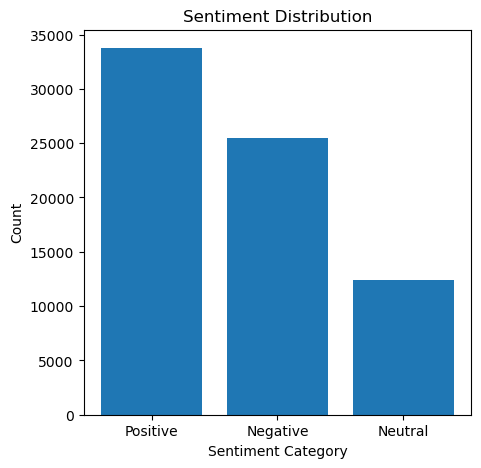

In [15]:
#calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

#create a bar chart for sentiment distribution
plt.figure(figsize=(5, 5))
plt.bar(sentiment_distribution.index, sentiment_distribution.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

#show the bar chart
plt.show()

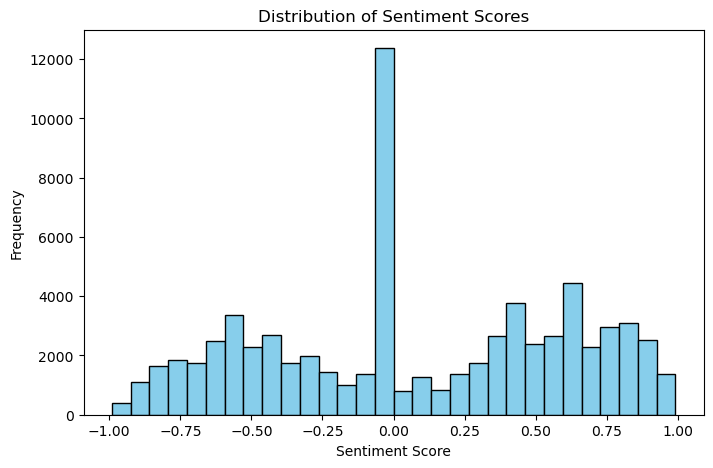

In [16]:
#create a histogram of sentiment scores
plt.figure(figsize=(8, 5))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Positive Sentiment Peak: A peak on the right side of the histogram corresponds to sentiment scores greater than 0, indicating positive sentiments. This suggests that a significant portion of the text data expresses positive sentiments.

Negative Sentiment Peak: Another peak on the left side of the histogram represents sentiment scores less than 0, signifying negative sentiments. This indicates the presence of text data expressing negative sentiments.

Neutral Sentiment: The central area of the histogram, around the score of 0, corresponds to neutral sentiments. It shows that a considerable volume of text data is neutral in nature.

### Text Length Analysis

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


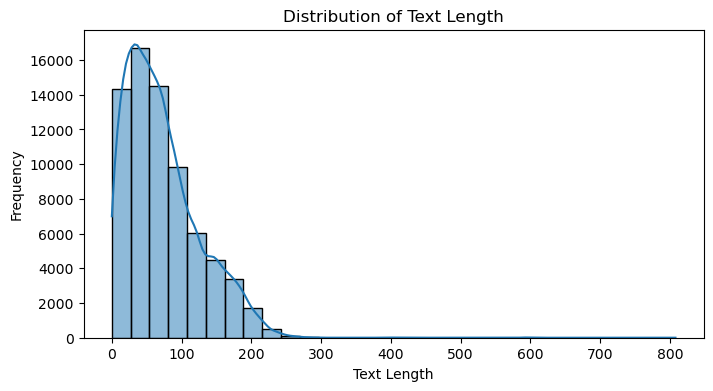

In [17]:
#for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

### Word Frequency Analysis

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


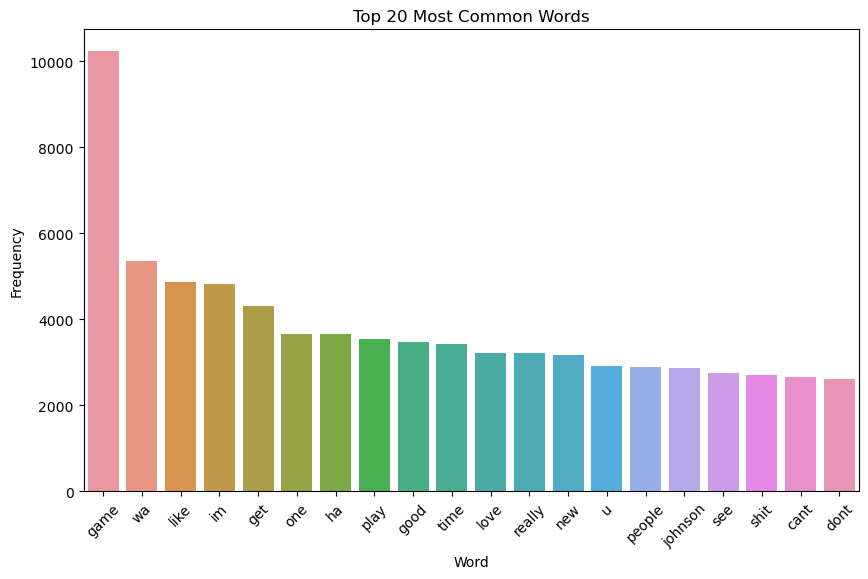

In [18]:
#word frequency analysis
from collections import Counter

words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

### Word Cloud of Lemmatized Social Media Content

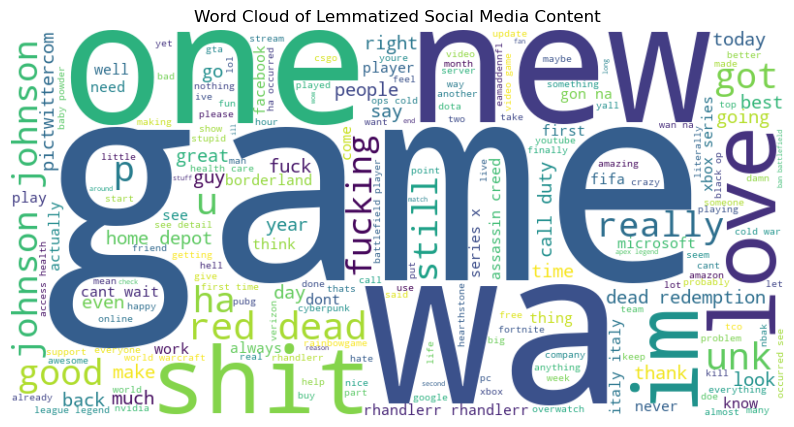

In [19]:
#join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
#generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()

### Word Cloud for Positive Sentiment

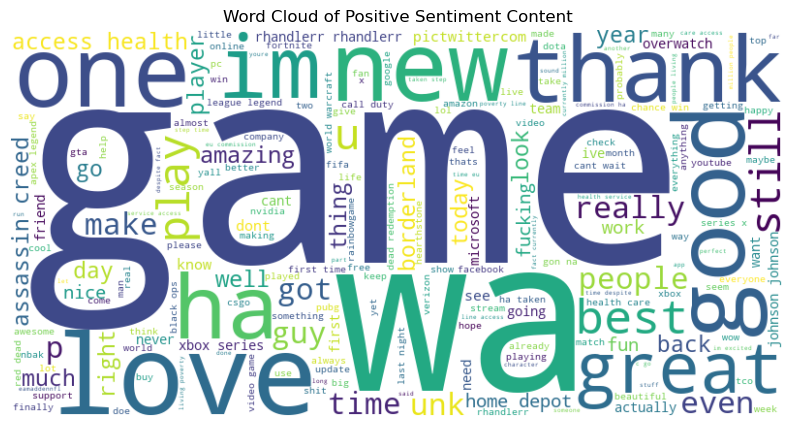

In [20]:
#filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']

#combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())

#generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)

#display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()

### Word Cloud for Negative Sentiment

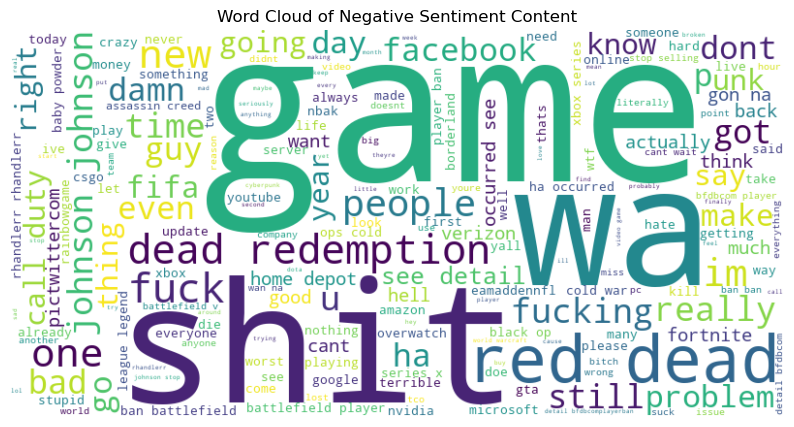

In [21]:
#filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']

#combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())

#generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)

#display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()

### Word Cloud for Neutral Sentiment

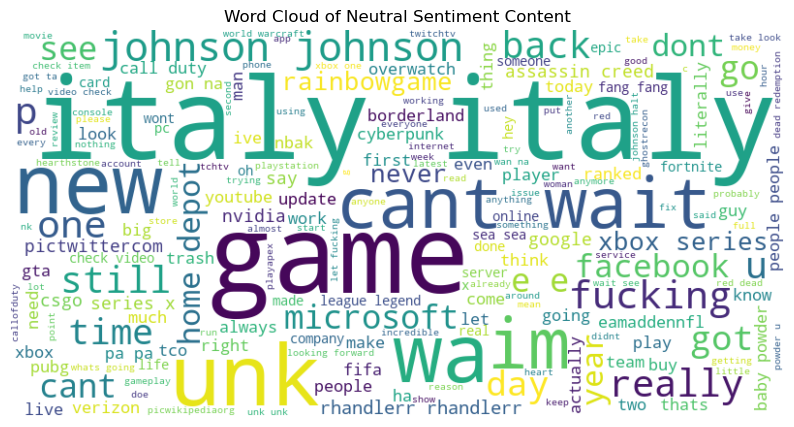

In [22]:
#filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']

#combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())

#generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)

#display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()

### Data Splitting

In [23]:
#assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction (Vectorization)

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Model Training

In [25]:
#initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')

#train the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [26]:
#predict on the test set
y_pred = model.predict(X_test_tfidf)

#evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9067122523025398
              precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      5066
     Neutral       0.89      0.85      0.87      2471
    Positive       0.92      0.93      0.93      6795

    accuracy                           0.91     14332
   macro avg       0.90      0.89      0.90     14332
weighted avg       0.91      0.91      0.91     14332

